### QEの65章のモデルをQEのメソッドを用いて考える


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import scipy.linalg as la

import quantecon as qe

### まずはLQを用いてモデルを観察する

In [107]:
# Set parameters
mu_d =8.0
rho = 0.05
gan = 12.0


α, β, ρ1, ρ2, σ = mu_d * (1 - rho), 0.95, rho, 0.0, 1.0

R = 1 / β
A = np.array([[1.0, 0.0, 0.0], [α, ρ1, ρ2], [0.0, 1.0, 0.0]])
C = np.array([[0.0], [σ], [0.0]])
G = np.array([[0.0, 1.0, 0.0]])
G_1 = np.array([[1.0, 0.0, 0.0]])

In [108]:
A12 = np.zeros((3, 1))
ALQ_l = np.hstack([A, A12])
ALQ_r = np.array([[-gan, 1.0, 0.0, R]])
ALQ = np.vstack([ALQ_l, ALQ_r])

ep = 1e-9
RLQ = np.array(
    [
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ep],
    ]
)

QLQ = np.array([1.0])
BLQ = np.array([0.0, 0.0, 0.0, -1.0]).reshape(4, 1)
CLQ = np.array([0.0, σ, 0.0, 0.0]).reshape(4, 1)
β_LQ = β

In [109]:
lqpi = qe.LQ(QLQ, RLQ, ALQ, BLQ, C=CLQ, beta=β_LQ)

In [110]:
P, F, d = lqpi.stationary_values()  # Compute value function and decision rule
ABF = ALQ - BLQ @ F  #  Form closed loop system

In [111]:
Tmp = ALQ - np.dot(BLQ, F)

iter_t = 400
d_0 = 0.0

eps = np.random.randn(iter_t)
y = np.array([[1.0, 0.0, 0.0, 0.0]])
# print(y[0])
# print(y.shape)
for i in range(iter_t):
    # print(i)
    # F, K, P, Pt = olrprobust(beta, A, B, C, Q, R_hyouka, sig)
    # Tmp = A -np.dot(B,F) + np.dot(C,K)
    # print(f"y = \n{np.dot(Tmp, y[0].T) + CLQ.T * eps[i]}")
    # print(y)
    # print(y.shape)
    y = np.insert(y, 0, np.dot(Tmp, y[0].T) + CLQ.T * eps[i], axis=0)

In [112]:
y = y[::-1]
# print(y)
k_get = y[:, 3]
d_get = y[:, 1]

one_get = y[:, 0]
x = np.array(range(iter_t + 1))

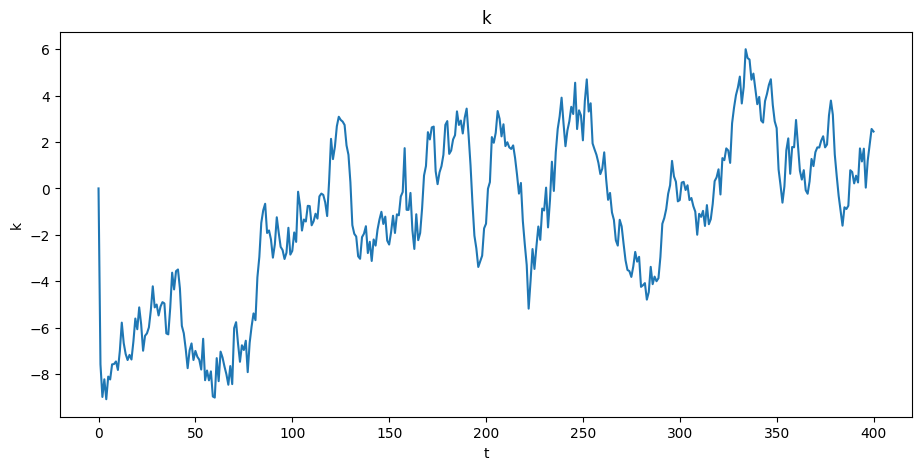

In [113]:
plt.figure()
plt.xlabel("t")
plt.ylabel("k")
plt.title("k")

plt.plot(x, k_get)

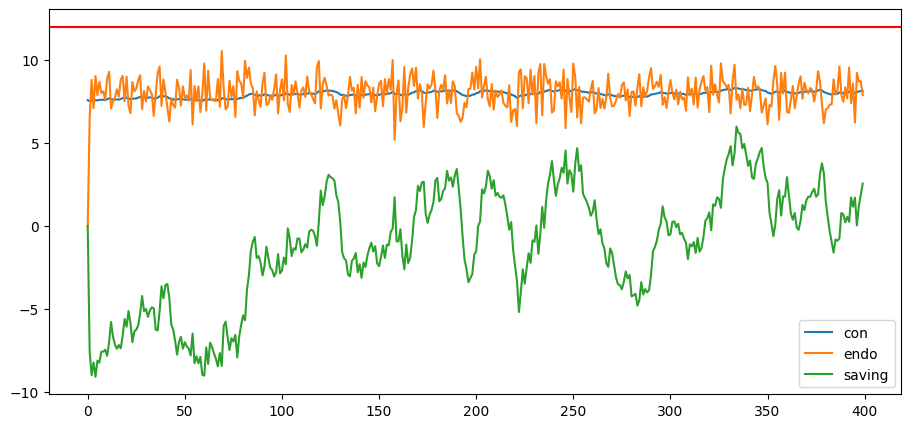

In [114]:
c = np.zeros(iter_t + 1)
# print("c size before %d"%c.shape)
c[0] = 0
where = 0
for i in range(iter_t):
    # print("k = %d"%k_get[(iter_t + 1) * where + i - 1])
    # print(i)
    # print(y[i])
    c[i] = -F @ y[i] + gan
    # print("c = %d"%c[i])

# print(c.shape)

plt.plot(np.array(range(iter_t)), c[:iter_t], label="con")
plt.plot(np.array(range(iter_t)), d_get[:iter_t], label="endo")
plt.plot(np.array(range(iter_t)), k_get[:iter_t], label="saving")
plt.axhline(y=gan, xmin=0.0, xmax=iter_t,color="r")
plt.legend()

### 次に差分方程式を用いた観察

In [115]:
# Use the above formulas to create the optimal policies for b_{t+1} and c_t

b_pol = G @ (np.eye(3, 3) - (R - 1) * β * la.inv(np.eye(3, 3) - β * A))

# 効用込み
c_pol_utility = (R - 1) * (β * G @ la.inv(np.eye(3, 3) - β * A) - gan / (R - 1) * G_1)
c_pol_c = (R - 1) * β * G @ la.inv(np.eye(3, 3) - β * A)
# Create the A matrix for a LinearStateSpace instance
A_LSS1 = np.vstack([A, b_pol])
A_LSS2 = np.array([0.0, 0.0, 0.0, 1.0]).reshape(-1, 1)
A_LSS = np.hstack([A_LSS1, A_LSS2])

# Create the C matrix for LSS methods
C_LSS = np.vstack([C, np.zeros(1)])

# Create the G_c matrix for LSS methods
G_LSS1_c = np.vstack([G, c_pol_c])
G_LSS2_c = np.vstack([np.zeros(1), R - 1])
G_LSS_c = np.hstack([G_LSS1_c, G_LSS2_c])

# Create the G_utirity matrix for LSS methods
G_LSS1_uti = np.vstack([G, c_pol_utility])
G_LSS2_uti = np.vstack([np.zeros(1), R - 1])
G_LSS_uti = np.hstack([G_LSS1_uti, G_LSS2_uti])

# Use the following values to start everyone off at b=0, initial incomes zero
μ_0 = np.array([1.0, 0.0, 0.0, 0.0])
Σ_0 = np.zeros((4, 4))

### ↓↓　LQの解との差も十分小さいことが確認できました。

In [116]:
ABF - A_LSS

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.43642810e-07, -1.79553652e-08,  0.00000000e+00,
        -1.80499915e-08]])

In [117]:
print(c_pol_utility, "\n", -F)

[[-4.41994751  0.05249344  0.        ]] 
 [[-4.41994765  0.05249346 -0.          0.0526316 ]]


In [118]:
def income_consumption_debt_series(A, C, G, μ_0, Σ_0, T=iter_t, npaths=25):
    """
    This function takes initial conditions (μ_0, Σ_0) and uses the
    LinearStateSpace class from QuantEcon to  simulate an economy
    npaths times for T periods. It then uses that information to
    generate some graphs related to the discussion below.
    """
    lss = qe.LinearStateSpace(A, C, G, mu_0=μ_0, Sigma_0=Σ_0)

    # Simulation/Moment Parameters
    moment_generator = lss.moment_sequence()

    # Simulate various paths
    bsim = np.empty((npaths, T))
    csim = np.empty((npaths, T))
    ysim = np.empty((npaths, T))

    for i in range(npaths):
        sims = lss.simulate(T)
        bsim[i, :] = sims[0][-1, :]
        csim[i, :] = sims[1][1, :]
        ysim[i, :] = sims[1][0, :]

    # Get the moments
    cons_mean = np.empty(T)
    cons_var = np.empty(T)
    debt_mean = np.empty(T)
    debt_var = np.empty(T)
    for t in range(T):
        μ_x, μ_y, Σ_x, Σ_y = next(moment_generator)
        cons_mean[t], cons_var[t] = μ_y[1], Σ_y[1, 1]
        debt_mean[t], debt_var[t] = μ_x[3], Σ_x[3, 3]

    return bsim, csim, ysim, cons_mean, cons_var, debt_mean, debt_var

def consumption_income_debt_figure(bsim, csim, ysim):

    # Get T
    T =  bsim.shape[1]

    # Create the first figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Plot consumption and income
    ax[0].plot(csim[0, :], label="c", color="b")
    ax[0].plot(ysim[0, :], label="y", color="g")
    ax[0].plot(csim.T, alpha=.1, color="b")
    ax[0].plot(ysim.T, alpha=.1, color="g")
    ax[0].legend(loc=4)
    ax[0].set(title="Nonfinancial Income, Consumption, and saving",
              xlabel="t", ylabel="y and c")

    # Plot debt
    ax[1].plot(bsim[0, :], label="k", color="r")
    ax[1].plot(bsim.T, alpha=.1, color="r")
    ax[1].legend(loc=4)
    ax[1].set(xlabel="t", ylabel="saving")

    fig.tight_layout()
    return fig

def consumption_debt_fanchart(csim, cons_mean, cons_var,
                              bsim, debt_mean, debt_var):
    # Get T
    T =  bsim.shape[1]

    # Create percentiles of cross-section distributions
    cmean = np.mean(cons_mean)
    c90 = 1.65 * np.sqrt(cons_var)
    c95 = 1.96 * np.sqrt(cons_var)
    c_perc_95p, c_perc_95m = cons_mean + c95, cons_mean - c95
    c_perc_90p, c_perc_90m = cons_mean + c90, cons_mean - c90

    # Create percentiles of cross-section distributions
    dmean = np.mean(debt_mean)
    d90 = 1.65 * np.sqrt(debt_var)
    d95 = 1.96 * np.sqrt(debt_var)
    d_perc_95p, d_perc_95m = debt_mean + d95, debt_mean - d95
    d_perc_90p, d_perc_90m = debt_mean + d90, debt_mean - d90


    # Create second figure
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    xvals = np.arange(T)

    # Consumption fan
    ax[0].plot(xvals, cons_mean, color="k")
    ax[0].plot(csim.T, color="k", alpha=.25)
    ax[0].fill_between(xvals, c_perc_95m, c_perc_95p, alpha=.25, color="b")
    ax[0].fill_between(xvals, c_perc_90m, c_perc_90p, alpha=.25, color="r")
    ax[0].set(title="Consumption/saving over time",
              ylim=(cmean-15, cmean+15), ylabel="consumption")

    # Debt fan
    ax[1].plot(xvals, debt_mean, color="k")
    ax[1].plot(bsim.T, color="k", alpha=.25)
    ax[1].fill_between(xvals, d_perc_95m, d_perc_95p, alpha=.25, color="b")
    ax[1].fill_between(xvals, d_perc_90m, d_perc_90p, alpha=.25, color="r")
    ax[1].set(xlabel="t", ylabel="saving")

    fig.tight_layout()
    return fig

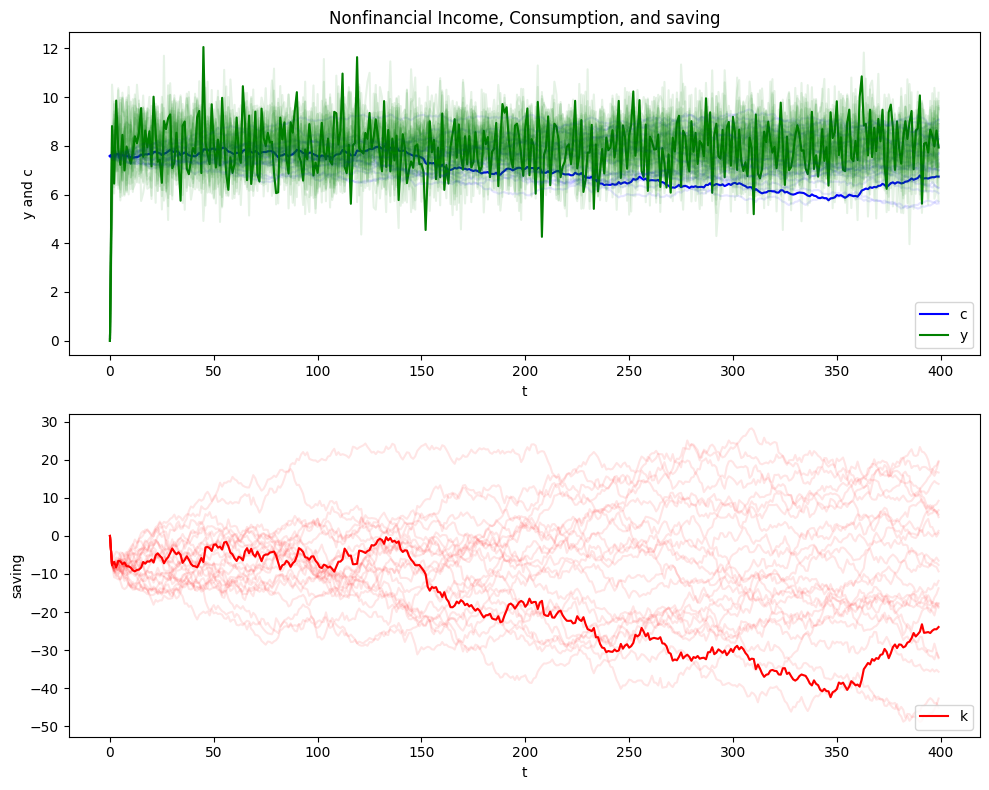

In [119]:
out = income_consumption_debt_series(A_LSS, C_LSS, G_LSS_c, μ_0, Σ_0)
bsim0, csim0, ysim0 = out[:3]
cons_mean0, cons_var0, debt_mean0, debt_var0 = out[3:]

consumption_income_debt_figure(bsim0, csim0, ysim0)

plt.show()

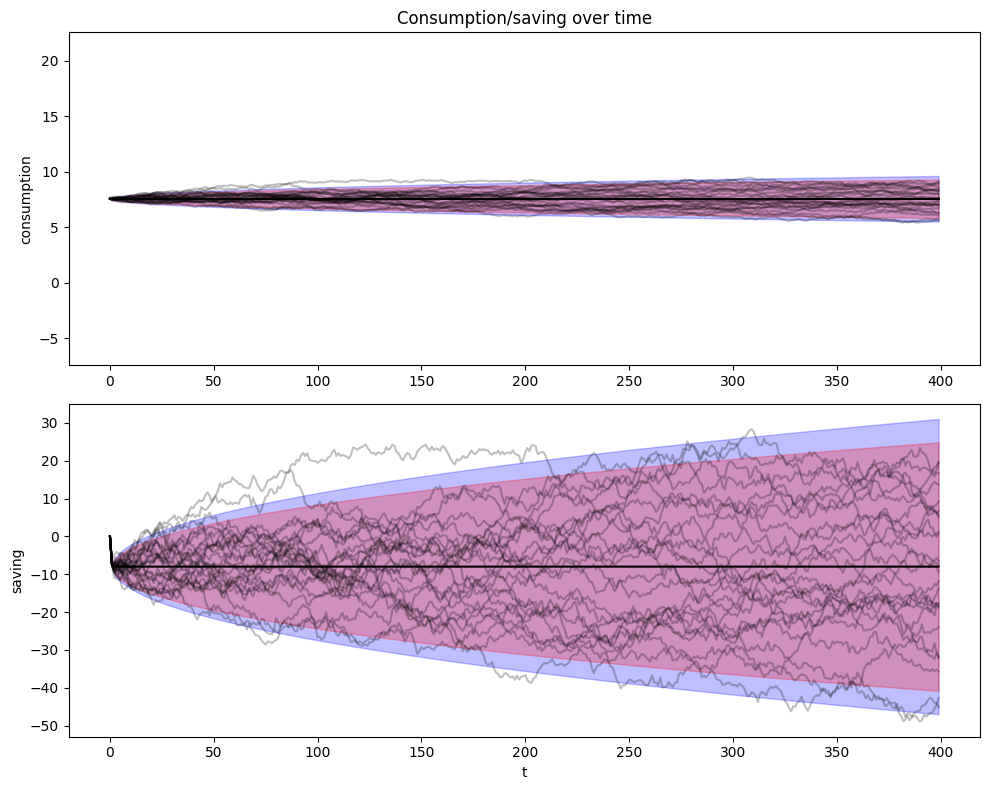

In [120]:
consumption_debt_fanchart(csim0, cons_mean0, cons_var0,
                          bsim0, debt_mean0, debt_var0)

plt.show()
